In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
select = tf.select if hasattr(tf, 'select') else tf.where

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [2]:
# Data params
input_dim = 784
output_dim = 10

# Network params
n_hidden_units = 50
activation_fn = tf.nn.relu

# Optimization params
batch_size = 1000
epochs_per_task = 5

n_stats = 1

# Reset optimizer after each age
reset_optimizer = True

In [3]:
from keras.utils import np_utils

task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9], [4,6],[8,1],[0,3],[2,4],[5,7]]
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9], [4,6],[8,1],[0,3],[2,9],[5,7]]
# task_labels = [[0,1,2,3,4], [5,6,7,8,9]]
n_tasks = len(task_labels)
training_datasets = utils.construct_split_mnist(task_labels, split='train')
validation_datasets = utils.construct_split_mnist(task_labels, split='test')
# training_datasets = utils.mk_training_validation_splits(full_datasets, split_fractions=(0.9, 0.1))

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    #print(sess.run(output_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    #print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(n_hidden_units, activation=activation_fn, input_shape=(input_dim,)))
#model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, kernel_initializer='zero', activation=masked_softmax))
#model.add(Dense(output_dim, activation=masked_softmax, input_shape=(input_dim,)))

from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory
from keras.callbacks import History 
from keras.callbacks import LambdaCallback

#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
protocol_name, protocol = protocols.FISHER_PROTOCOL('sum')
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
# opt = SGD(1e-3)
# opt = RMSprop(lr=1e-3)
oopt = KOOptimizer(opt, model=model, compute_fisher=True, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
model.model._make_train_function()
saved_weights = model.get_weights()

save_weights_epoch=[]
save_loss_epoch=[]
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: save_weights_epoch.append(model.get_weights()))
history = LossHistory()
callbacks = [history]
datafile_name = "split_mnist_data_%s.pkl.gz"%protocol_name

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [5]:
def run_fits(cvals, training_data, valid_data, eval_on_train_set=False, nstats=1):
    acc_mean = dict()
    acc_std = dict()
    model_weights_save = []   #Empty list to save the model weights aftertraining each task
    for cidx, cval_ in enumerate(tqdm(cvals)):
        runs = []
        for runid in range(nstats):
            sess.run(tf.global_variables_initializer())
            # model.set_weights(saved_weights)
            cstuffs = []
            evals = []
            print("setting cval")
            cval = cval_
            oopt.set_strength(cval)
            oopt.init_task_vars()
            print("cval is", sess.run(oopt.lam))
            for age, tidx in enumerate(range(n_tasks)):
                print("Age %i, cval is=%f"%(age,cval))
                print("settint output mask")
                set_active_outputs(task_labels[age])
                stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=[history,print_weights])
                oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                oopt.update_task_vars()
                ftask = []
                model_weights_save.append(model.get_weights()) #Save the model weights aftertraining each task
                for j in range(n_tasks):
                    set_active_outputs(task_labels[j])
                    if eval_on_train_set:
                        f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                    else:
                        f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                    ftask.append(np.mean(f_))
                evals.append(ftask)
                cstuffs.append(stuffs)

                # Re-initialize optimizater variables
                if reset_optimizer:
                    oopt.reset_optimizer()

            evals = np.array(evals)
            runs.append(evals)
        
        runs = np.array(runs)
        acc_mean[cval_] = runs.mean(0)
        acc_std[cval_] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std),model_weights_save,cstuffs

# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [1.0]
print(cvals)

[1.0]


In [6]:
#%%capture
recompute_data = True
if recompute_data:
    data,model_weights_save,cstuffs = run_fits(cvals, training_datasets, validation_datasets, eval_on_train_set=False, nstats=n_stats)
    utils.save_zipped_pickle(data, datafile_name)

  0%|          | 0/1 [00:00<?, ?it/s]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
Epoch 1/5
12665/12665 [==============================] - 0s - loss: 0.6306 - acc: 0.9459     
Epoch 2/5
12665/12665 [==============================] - 0s - loss: 0.2854 - acc: 0.9922     
Epoch 3/5
 1000/12665 [=>............................] - ETA: 0s - loss: 0.1213 - acc: 0.9920

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108675). Check your callbacks.
  % delta_t_median)


12665/12665 [==============================] - 0s - loss: 0.0661 - acc: 0.9948     
Epoch 4/5
12665/12665 [==============================] - 0s - loss: 0.0234 - acc: 0.9957     
Epoch 5/5
12665/12665 [==============================] - 0s - loss: 0.0140 - acc: 0.9973     
Age 1, cval is=1.000000
settint output mask
Epoch 1/5
12089/12089 [==============================] - 0s - loss: 0.6638 - acc: 0.6926     
Epoch 2/5
12089/12089 [==============================] - 0s - loss: 0.5865 - acc: 0.8741     
Epoch 3/5
12089/12089 [==============================] - 0s - loss: 0.5169 - acc: 0.9112     
Epoch 4/5
12089/12089 [==============================] - 0s - loss: 0.4607 - acc: 0.9355     
Epoch 5/5
12089/12089 [==============================] - 0s - loss: 0.4172 - acc: 0.9404     
Age 2, cval is=1.000000
settint output mask
Epoch 1/5
11263/11263 [==============================] - 0s - loss: 0.6263 - acc: 0.7114     
Epoch 2/5
11263/11263 [==============================] - 0s - loss: 0.5372 -

100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


In [27]:
#Inspection of behavior of diagonal elements of Fisher matrix 
from numpy import count_nonzero
last_epoch_batchindex = []
counter = 0
for i,j in enumerate(history.batchindex):
    try:
        if history.batchindex[i+1] > j:
            pass
        else:
            counter = counter+1
            if counter%epochs_per_task == 0:
                last_epoch_batchindex.append(i)
    except:
        last_epoch_batchindex.append(i)

print('Batch-id for last epoch of each task:',last_epoch_batchindex)
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    print('Fisher diagonal elements for task {0} is '.format(i), history.fisher_save1[epoch_id].shape, history.fisher_save2[epoch_id].shape, history.fisher_save3[epoch_id].shape, history.fisher_save4[epoch_id].shape)

non_zero_imp_param = []
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    non_zero_imp_param.append(count_nonzero(history.fisher_save1[epoch_id])+ count_nonzero(history.fisher_save2[epoch_id])+ count_nonzero(history.fisher_save3[epoch_id])+ count_nonzero(history.fisher_save4[epoch_id]))
    print('Number of non-zero diagonal elements of Fisher for task {0} is '.format(i),non_zero_imp_param[i])
    

Batch-id for last epoch of each task: [64, 129, 189, 254, 314]
*----------------------------*
Fisher diagonal elements for task 0 is  (50,) (784, 50) (50, 10) (10,)
Fisher diagonal elements for task 1 is  (50,) (784, 50) (50, 10) (10,)
Fisher diagonal elements for task 2 is  (50,) (784, 50) (50, 10) (10,)
Fisher diagonal elements for task 3 is  (50,) (784, 50) (50, 10) (10,)
Fisher diagonal elements for task 4 is  (50,) (784, 50) (50, 10) (10,)
*----------------------------*
Number of non-zero diagonal elements of Fisher for task 0 is  39352
Number of non-zero diagonal elements of Fisher for task 1 is  39454
Number of non-zero diagonal elements of Fisher for task 2 is  39556
Number of non-zero diagonal elements of Fisher for task 3 is  39658
Number of non-zero diagonal elements of Fisher for task 4 is  39760


In [19]:
#Inspection of losses after every task 
loss_after_task=[]
print('Batch-id for last epoch of each task:',last_epoch_batchindex)
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    loss_after_task.append(history.losses[epoch_id])
    print('Loss after task {0} '.format(i), history.losses[epoch_id]) 
print('*----------------------------*')

#Inspection of surrogate loss or regularization (sum(big_omega x (theta'-theta))) after every task 
surrogate_loss_after_task=[]
for i,epoch_id in enumerate(last_epoch_batchindex):
    surrogate_loss_after_task.append(history.regs[epoch_id])
    print('Surrogate loss after task {0} '.format(i), history.regs[epoch_id]) 

Batch-id for last epoch of each task: [64, 129, 189, 254, 314]
*----------------------------*
Loss after task 0  0.016608756
Loss after task 1  0.3994651
Loss after task 2  0.39945087
Loss after task 3  0.26456866
Loss after task 4  0.39205825
*----------------------------*
Surrogate loss after task 0  0.0
Surrogate loss after task 1  0.028393865
Surrogate loss after task 2  0.0146697
Surrogate loss after task 3  0.014084756
Surrogate loss after task 4  0.0077208546


In [20]:
data = utils.load_zipped_pickle(datafile_name)
print(cvals)

print(model.summary())
'''
print(data['mean'],model.summary())
for k in cvals:
    for i in range(n_tasks):
        for j in range(i):
            data['mean'][k][j][i] = 0
            data['std'][k][j][i] = 0
'''

[1.0]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
None


"\nprint(data['mean'],model.summary())\nfor k in cvals:\n    for i in range(n_tasks):\n        for j in range(i):\n            data['mean'][k][j][i] = 0\n            data['std'][k][j][i] = 0\n"

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(-5.0, 0.0)


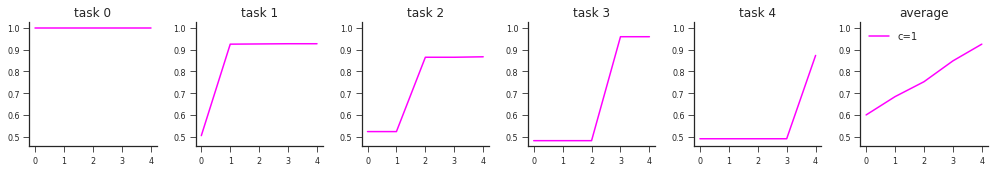

In [21]:
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())

import pdb
figure(figsize=(14, 2.5))
axs = [subplot(1,n_tasks+1,1)]#, None, None]

for i in range(1, n_tasks + 1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal)
    label = "c=%g"%cval
    average = mean_vals.mean(1)
    axs[-1].plot(average, c=colorVal, label=label)
    
for i, ax in enumerate(axs):
    ax.legend(loc='best')
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
gcf().tight_layout()
sns.despine()
plt.savefig('MNIST_Accuracy_10task.pdf')

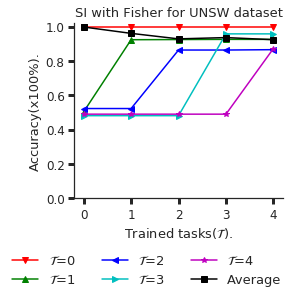

In [22]:
import pdb
figure(figsize=(4, 4.5))
axs = [subplot(1,1,1)]#, None, None]
fontsize = 13

keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

colorVal = ['r','g','b','c','m','k','y','tomato']
marker=["v","^","<",">","*","s","h","x","."]

mean_stuff=[]
std_stuff=[]
for i in range(len(data['mean'][cval])):
    mean_stuff.append(data['mean'][cval][i][:i+1].mean())
    std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        label = "$\mathcal{T}$=%g"%j
        axs[0].plot(range(n_tasks), mean_vals[:, j], marker=marker[j], c=colorVal[j], label=label)
    axs[0].plot(range(n_tasks), mean_stuff, marker=marker[j+1], c=colorVal[j+1], label='Average')
    axs[0].legend(loc='upper right',prop={'size': fontsize}, bbox_to_anchor=(1.05, -0.25), ncol=3)
    axs[0].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
    axs[0].set_ylabel('Accuracy(x100%).',fontsize=fontsize)
    axs[0].set_xticks(range(n_tasks))
    axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axs[0].tick_params(labelsize='large', width=3)
    axs[0].set_title('SI with Fisher for UNSW dataset', fontsize=fontsize)
#plt.legend(bbox_to_anchor=(0.78, 0.66),bbox_transform=plt.gcf().transFigure)
gcf().tight_layout()
sns.despine()
plt.savefig('MNIST_SIFisher_congestion.pdf',bbox_inches = "tight")

In [23]:
Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
for i in range(len(model_weights_save)):
    if i == 0:
        Flatten_weights.append(list(flatten(save_weights_epoch[epochs_per_task-2])))
        Flatten_weights.append(list(flatten(save_weights_epoch[epochs_per_task-1])))
    Flatten_weights.append(list(flatten(model_weights_save[i]))) 

Extract_model_params = []
for i in range(len(Flatten_weights)):   
    Extract_model_params.append(Flatten_weights[i])
    
gradient_save=[]
for i in range(1,len(Extract_model_params)):
    if i == 2:
        pass
    else :
        temp=list(np.asarray(Extract_model_params[i])-np.asarray(Extract_model_params[i-1]))
        gradient = [j/0.001 for j in temp]
        gradient_save.append(gradient)

In [24]:
len(gradient_save[0])

39760

In [25]:
#Creating the Hessian matrix diagonal emlements rom the gradients and finding rank by counting 
#non-zero diagonal elements
import math
Hessian_diagonal = []
Rank_Hessian_matrix = []
for k in range(len(gradient_save)):
    Hessian_diagonal = [elem*elem for elem in gradient_save[k]]
    rank_Hessian_matrix = count_nonzero(np.diag(np.asarray(Hessian_diagonal)))
    Rank_Hessian_matrix.append(rank_Hessian_matrix)
    print('Rank of the Hessian Matrix after task=',k,'is :',rank_Hessian_matrix)
    
rank_Hessian_matrix = []
for i,val in enumerate(Rank_Hessian_matrix):
    if i == 0 or val > rank_Hessian_matrix[i-1]:
        rank_Hessian_matrix.append(val)
    else:
        curr_task_rank  = rank_Hessian_matrix[i-1] + (rank_Hessian_matrix[i-1] - val) 
        if curr_task_rank < 39760:
            rank_Hessian_matrix.append(curr_task_rank)
        else:
            rank_Hessian_matrix.append(39760)
print(rank_Hessian_matrix)

Rank of the Hessian Matrix after task= 0 is : 30414
Rank of the Hessian Matrix after task= 1 is : 32686
Rank of the Hessian Matrix after task= 2 is : 31048
Rank of the Hessian Matrix after task= 3 is : 34143
Rank of the Hessian Matrix after task= 4 is : 30069
[30414, 32686, 34324, 34505, 38941]


/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:330: UserWarning: tight_layout not applied: number of rows in subplot specifications mustbe multiples of one another.
  warnings.warn('tight_layout not applied: '


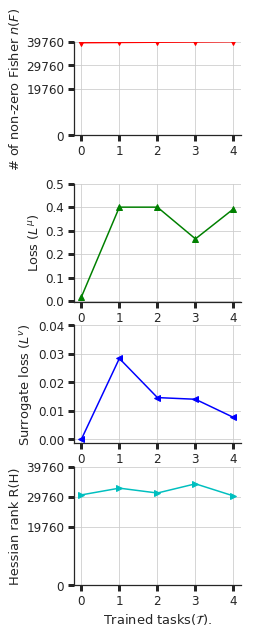

In [31]:
import pdb
figure(figsize=(3, 10))
axs = [subplot(5,1,1)]#, None, None]
for i in range(1, 4):
    axs.append(subplot(4, 1, i+1, sharex=axs[0]))
fontsize = 13

colorVal = ['r','g','b','c','m','k','y']
marker=["v","^","<",">","*","s"]

plots = [non_zero_imp_param,loss_after_task,surrogate_loss_after_task,Rank_Hessian_matrix]
ylabel = ['# of non-zero Fisher $n(F)$', 'Loss ($L^\mu$)', 'Surrogate loss ($L^v$)','Hessian rank R(H)']
ytick = [[0, 19760, 29760, 39760], [0,0.1,0.2,0.3,0.4,0.5],[0,0.01,0.02,0.03, 0.04], [0, 19760, 29760, 39760]]
title = ['Number of non-zero importance.', 'Loss', 'Surrogate loss', 'Hessian rank']
for i in range(4):
    axs[i].plot(range(n_tasks), plots[i], marker=marker[i], c=colorVal[i])
    axs[i].set_ylabel(ylabel[i],fontsize=fontsize)
    axs[i].set_yticks(ytick[i])
    axs[i].tick_params(labelsize='large', width=3)
    axs[i].grid()
axs[-1].set_xticks(range(n_tasks))
axs[-1].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
plt.tight_layout()
sns.despine()
plt.savefig('MNIST_SIFisher_evalcongestion.pdf',bbox_inches = "tight")

--------------Euclidean distance--------------------
Between task 0 and 1 : 4.023771893021162
Between task 1 and 2 : 2.434794593732082


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """


Between task 2 and 3 : 3.940232823326087
Between task 3 and 4 : 0.8091160166053282
--------------Cosine distance--------------------
Between task 0 and 1 : 0.939


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


Between task 1 and 2 : 0.979
Between task 2 and 3 : 0.95
Between task 3 and 4 : 0.998
--------------Jaccard similarity--------------------
Between task 0 and 1 : 0.09423138360673955
Between task 1 and 2 : 0.12100997771690535
Between task 2 and 3 : 0.0750746673907141
Between task 3 and 4 : 0.13919618900033
--------------Sequence Matcher--------------------
Between task 0 and 1 : 0.17794265593561368
Between task 1 and 2 : 0.21913983903420522
Between task 2 and 3 : 0.14129778672032192
Between task 3 and 4 : 0.2437374245472837


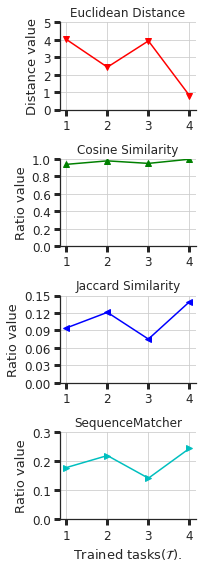

In [34]:
#Heuristic metric: Weights Pattern after training each task
from math import*
#1. Euclidean distance
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

#2. Cosine Similarity
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)

#3. Jaccard similarity
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

#4. Using SequenceMatcher    
from difflib import SequenceMatcher

Flatten_weights=[]
#Flattening the weights into a list
def flatten(x):
    try:
        it = iter(x)
    except TypeError:
        yield x
    else:
        for i in it:
            for j in flatten(i):
                yield j
                
print("--------------Euclidean distance--------------------")
Eu_distance = []
for i in range(1,n_tasks):
    eu_dist = euclidean_distance(list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i])))
    Eu_distance.append(eu_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,eu_dist))

print("--------------Cosine distance--------------------")
Cos_distance = []
for i in range(1,n_tasks):
    cos_dist = cosine_similarity(list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i])))
    Cos_distance.append(cos_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,cos_dist))
    
    
print("--------------Jaccard similarity--------------------")
Jac_distance = []
for i in range(1,n_tasks):
    jac_dist = jaccard_similarity(list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i])))
    Jac_distance.append(jac_dist)
    print("Between task {0} and {1} : {2}".format(i-1,i,jac_dist))

print("--------------Sequence Matcher--------------------")
Seq_matcher = []
for i in range(1,n_tasks):
    seq_matcher = SequenceMatcher(None,list(flatten(model_weights_save[i-1])),list(flatten(model_weights_save[i]))).ratio()
    Seq_matcher.append(seq_matcher)
    print("Between task {0} and {1} : {2}".format(i-1,i,seq_matcher))
    
import pdb
figure(figsize=(3, 8))
subplots_adjust(hspace=0.25,
                    wspace=0.35)
axs = [plt.subplot(4,1,1)]#, None, None]
for i in range(1, 4):
    axs.append(subplot(4, 1, i+1, sharex=axs[0]))
fontsize = 13

colorVal = ['r','g','b','c','m','k','y']
marker=["v","^","<",">","*","s"]

plots = [Eu_distance,Cos_distance,Jac_distance,Seq_matcher]
ylabel = ['Distance value', 'Ratio value', 'Ratio value','Ratio value']
ytick = [[0, 1, 2, 3, 4, 5], [0, 0.2, 0.4, 0.6, 0.8, 1],[0, 0.03, 0.06, 0.09, 0.12, 0.15], [0, 0.1, 0.2, 0.3]]
title = ['Euclidean Distance', 'Cosine Similarity', 'Jaccard Similarity', 'SequenceMatcher']
for i in range(4):
    axs[i].plot(range(1,n_tasks), plots[i], marker=marker[i], c=colorVal[i])
    axs[i].set_ylabel(ylabel[i],fontsize=fontsize)
    axs[i].set_yticks(ytick[i])
    axs[i].tick_params(labelsize='large', width=3)
    axs[i].grid()
    axs[i].set_title(title[i])
axs[-1].set_xticks(range(1,n_tasks))
axs[-1].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
plt.tight_layout()
sns.despine()
plt.savefig('UNSW_SIFisher_Similaritymetric.pdf',bbox_inches = "tight")

In [35]:
#Heuristic metric: Weights Pattern between task 0 and last task 
from math import*
#1. Euclidean distance
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

#2. Cosine Similarity
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)

#3. Jaccard similarity
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

#4. Using SequenceMatcher    
from difflib import SequenceMatcher


eu_dist = euclidean_distance(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Euclidean distance between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,eu_dist))

cos_dist = cosine_similarity(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Cosine angle between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,cos_dist))

jac_dist = jaccard_similarity(list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1])))
print("Jaccard similarity between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,jac_dist))

seq_matcher = SequenceMatcher(None,list(flatten(model_weights_save[0])),list(flatten(model_weights_save[-1]))).ratio()
print("Sequence angle between task {0} and {1} : {2}".format(0,len(model_weights_save)-1,seq_matcher))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


Euclidean distance between task 0 and 4 : 6.247616591144154
Cosine angle between task 0 and 4 : 0.869
Jaccard similarity between task 0 and 4 : 0.05191609358996528
Sequence angle between task 0 and 4 : 0.0976861167002012


TypeError: 'list' object is not callable

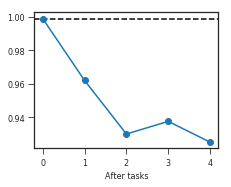

In [36]:
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
fig = plt.figure(figsize=(3.3,2.5))
ax = plt.subplot(111)

for cval in sorted_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(0,n_tasks+), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(0,n_tasks), mean_stuff, yerr=std_stuff, fmt='o-', label="c=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle='--', color='k')
xlabel('After tasks')
ylabel('Fraction correct')
legend(loc='best')
xlim(0, n_tasks)
ylim(0.7, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.savefig('MNIST_Accuracy_10task_fractional_correctness.pdf')